In [1]:

!nvidia-smi -L || true

!pip -q install transformers==4.41.2 datasets==2.20.0 accelerate==0.31.0 evaluate==0.4.2 scikit-learn==1.4.2 matplotlib==3.8.4


/bin/bash: line 1: nvidia-smi: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2

Importing configs for setting up the environment

In [5]:
!pip -q install --upgrade accelerate

In [36]:
#@title 🔧 Clean reinstall (then **Runtime → Restart runtime**)
!pip uninstall -y transformers accelerate -q
!pip install -q "transformers==4.48.2" "accelerate==1.10.1" \
               "datasets==2.20.0" "evaluate==0.4.2" "scikit-learn==1.4.2"

import transformers, accelerate
print("transformers:", transformers.__version__, "| accelerate:", accelerate.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.5.0 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-lear

# Upload dataset, mount to drive

In [5]:
#@title 🔗 Option B: Mount Google Drive (then set DATA_PATH to your CSV)
from google.colab import drive
drive.mount('/content/drive')

# Example path (edit to your file location in Drive)
DATA_PATH = "/content/Symptom2Disease.csv"  # <-- change if needed
print("Using:", DATA_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: /content/Symptom2Disease.csv


In [6]:
#@title 🧹 Load data & split
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv(DATA_PATH)
df.columns = [c.lower() for c in df.columns]
assert {"label","text"}.issubset(df.columns), f"CSV must have columns label,text; got {df.columns.tolist()}"
df = df.dropna(subset=["label","text"]).reset_index(drop=True)

print(f"Samples: {len(df)} | Classes: {df['label'].nunique()}")
label_list = sorted(df["label"].unique().tolist())
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

# Stratified 70/10/20 → 80/20 then 12.5% of 80% becomes val
trainval_df, test_df = train_test_split(df, test_size=0.20, stratify=df["label_id"], random_state=42)
train_df, val_df     = train_test_split(trainval_df, test_size=0.125, stratify=trainval_df["label_id"], random_state=42)

print(f"Split sizes → train={len(train_df)} ({len(train_df)/len(df):.0%}), "
      f"val={len(val_df)} ({len(val_df)/len(df):.0%}), test={len(test_df)} ({len(test_df)/len(df):.0%})")

display(df["label"].value_counts().sort_index().rename("count").to_frame().T)  # quick glance

Samples: 1200 | Classes: 24
Split sizes → train=840 (70%), val=120 (10%), test=240 (20%)


label,Acne,Arthritis,Bronchial Asthma,Cervical spondylosis,Chicken pox,Common Cold,Dengue,Dimorphic Hemorrhoids,Fungal infection,Hypertension,...,Pneumonia,Psoriasis,Typhoid,Varicose Veins,allergy,diabetes,drug reaction,gastroesophageal reflux disease,peptic ulcer disease,urinary tract infection
count,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50


In [8]:
#@title ✂️ Tokenization & Dataset objects
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

MODEL_NAME = "roberta-base"   # can try roberta-large if you have more GPU
MAX_LEN    = 192              # try 128 / 192 / 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

train_ds = Dataset.from_pandas(train_df[["text","label_id"]]).rename_columns({"label_id":"labels"}).map(tokenize_batch, batched=True)
val_ds   = Dataset.from_pandas(val_df[["text","label_id"]]).rename_columns({"label_id":"labels"}).map(tokenize_batch, batched=True)
test_ds  = Dataset.from_pandas(test_df[["text","label_id"]]).rename_columns({"label_id":"labels"}).map(tokenize_batch, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
len(train_ds), len(val_ds), len(test_ds)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

(840, 120, 240)

In [24]:
#@title 📏 Metrics: accuracy, macro-F1, top-3 accuracy
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    macro = f1_score(labels, preds, average="macro")
    # top-3 accuracy
    top3 = None
    try:
        top3_idx = np.argsort(-logits, axis=1)[:, :3]
        top3 = np.mean([labels[i] in row for i, row in enumerate(top3_idx)])
    except Exception:
        top3 = 0.0
    return {"accuracy": acc, "macro_f1": macro, "top3_acc": top3}

In [11]:
#@title 🧠 Model init
from transformers import AutoModelForSequenceClassification
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

num_labels = len(label_list)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(DEVICE)

def set_frozen(m, n_layers_freeze=4, frozen=True):
    # Freeze embeddings + bottom N encoder layers
    for p in m.roberta.embeddings.parameters():
        p.requires_grad = not (frozen)
    for i, layer in enumerate(m.roberta.encoder.layer):
        if i < n_layers_freeze:
            for p in layer.parameters():
                p.requires_grad = not (frozen)

Using device: cpu


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import TrainingArguments
print(help(TrainingArguments))

Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.Sch

In [23]:
#@title 🧊 Phase 1: Freeze lower layers for 1 epoch
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

N_LAYERS_TO_FREEZE = 4  # try 4–6
set_frozen(model, n_layers_freeze=N_LAYERS_TO_FREEZE, frozen=True)

args_phase1 = TrainingArguments(
    output_dir="/content/roberta_phase1",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Added this line
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    label_smoothing_factor=0.1,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    logging_steps=50,
    report_to="none",
    seed=42
)

trainer1 = Trainer(
    model=model,
    args=args_phase1,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer1.train()
eval_phase1 = trainer1.evaluate()
eval_phase1
# ==== FIX ADD-ON: Save a clean copy for inference ====
try:
    _mdl = trainer
except NameError:
    try:
        _mdl = trainer2
    except NameError:
        _mdl = trainer1
try:
    _mdl.save_model("/content/roberta_model")
    tokenizer.save_pretrained("/content/roberta_model")
    print("Saved clean model to /content/roberta_model")
except Exception as e:
    print("(Note) Could not save clean model:", e)


/tmp/ipython-input-3882808767.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Top3 Acc
1,2.532800,2.096824,0.675000,0.615953,0.891667


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.0968241691589355,
 'eval_accuracy': 0.675,
 'eval_macro_f1': 0.6159534909534911,
 'eval_top3_acc': 0.8916666666666667,
 'eval_runtime': 19.2491,
 'eval_samples_per_second': 6.234,
 'eval_steps_per_second': 0.208,
 'epoch': 1.0}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TEST — accuracy: 0.7125 | macro-F1: 0.6774 | top-3: 0.8875
                                 precision    recall  f1-score   support

                           Acne     1.0000    1.0000    1.0000        10
                      Arthritis     0.7143    1.0000    0.8333        10
               Bronchial Asthma     0.6154    0.8000    0.6957        10
           Cervical spondylosis     0.9091    1.0000    0.9524        10
                    Chicken pox     0.5000    0.4000    0.4444        10
                    Common Cold     0.6667    0.2000    0.3077        10
                         Dengue     1.0000    0.1000    0.1818        10
          Dimorphic Hemorrhoids     1.0000    1.0000    1.0000        10
               Fungal infection     0.6250    1.0000    0.7692        10
                   Hypertension     1.0000    0.6000    0.7500        10
                       Impetigo     0.8182    0.9000    0.8571        10
                       Jaundice     0.9091    1.0000    0.9524  

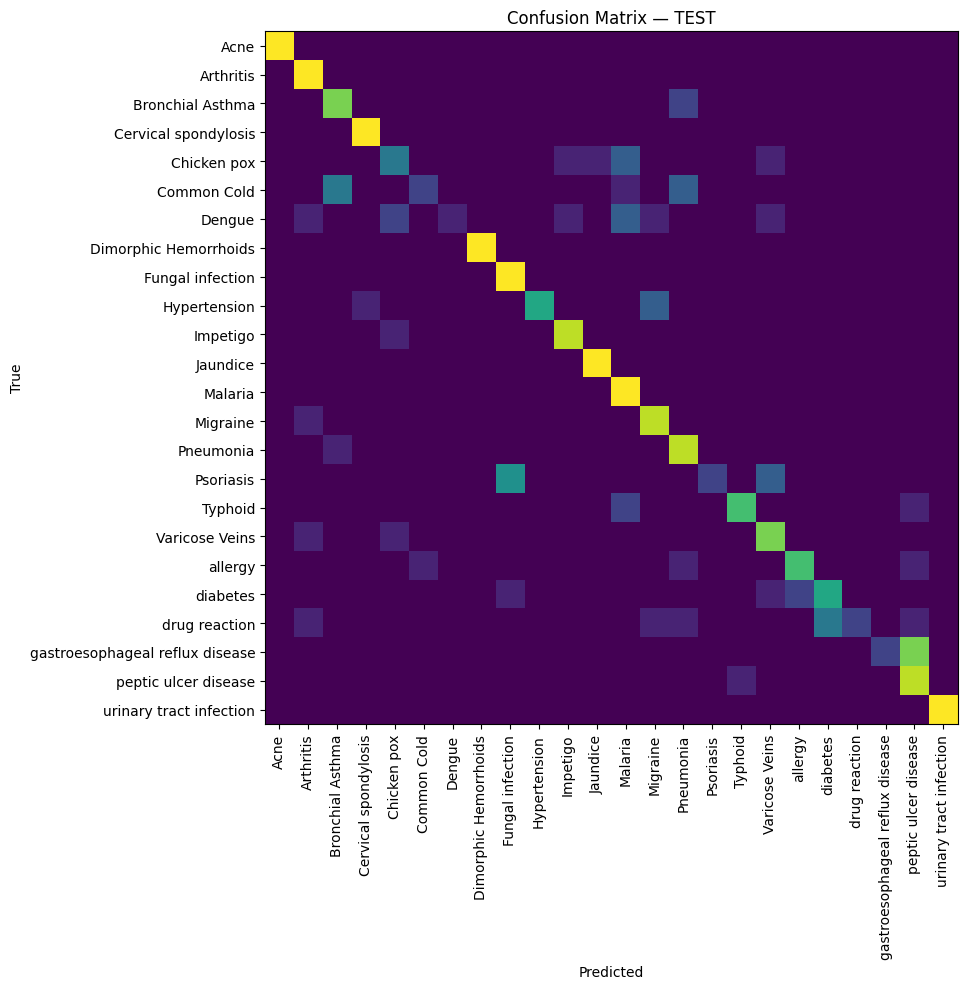

In [30]:
#@title 🧪 Test evaluation & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas

# Assume DATA_PATH is defined in a previous cell, or define it here
# Example path (edit to your file location in Drive)
DATA_PATH = "/content/Symptom2Disease.csv"  # <-- change if needed

# Load data and define id2label, num_labels
df = pd.read_csv(DATA_PATH) # Load the dataframe
df.columns = [c.lower() for c in df.columns]
label_list = sorted(df["label"].unique().tolist())
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}
num_labels = len(label_list)


pred = trainer1.predict(test_ds)
logits = pred.predictions
test_labels = np.array(pred.label_ids)
test_preds = logits.argmax(-1)

test_acc  = accuracy_score(test_labels, test_preds)
test_f1m  = f1_score(test_labels, test_preds, average="macro")
top3_idx  = np.argsort(-logits, axis=1)[:, :3]
test_top3 = np.mean([test_labels[i] in row for i, row in enumerate(top3_idx)])

print(f"TEST — accuracy: {test_acc:.4f} | macro-F1: {test_f1m:.4f} | top-3: {test_top3:.4f}")

# Per-class report
print(classification_report(
    test_labels, test_preds,
    target_names=[id2label[i] for i in range(num_labels)], digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds, labels=list(range(num_labels)))
plt.figure(figsize=(10,10))
plt.imshow(cm)
plt.xticks(ticks=np.arange(num_labels), labels=[id2label[i] for i in range(num_labels)], rotation=90)
plt.yticks(ticks=np.arange(num_labels), labels=[id2label[i] for i in range(num_labels)])
plt.title("Confusion Matrix — TEST")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [42]:
#@title 🔮 Inference helper (top-1 and top-3) — FIXED
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch, os, json, glob

# Unchanged from your TrainingArguments(output_dir=...) earlier
BASE_DIR = "/content/roberta_phase1"

# If you also saved a clean copy via trainer.save_model(...), prefer this:
SAVE_DIR = "/content/roberta_model"   # optional; used if present

# Robust defaults so this cell works even if earlier vars aren't defined here
try:
    DEVICE
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    MAX_LEN
except NameError:
    MAX_LEN = 192  # keep in sync with your tokenization cell

def pick_model_dir():
    """Return a directory that contains a valid transformers model
    (i.e., has config.json + weights). Tries SAVE_DIR, then BASE_DIR,
    then the newest checkpoint under BASE_DIR."""
    # 1) Prefer a clean saved dir
    if os.path.isdir(SAVE_DIR) and os.path.isfile(os.path.join(SAVE_DIR, "config.json")):
        return SAVE_DIR
    # 2) If BASE_DIR itself holds a model (rare)
    if os.path.isfile(os.path.join(BASE_DIR, "config.json")):
        return BASE_DIR
    # 3) Otherwise pick the most recent checkpoint-*
    ckpts = sorted(glob.glob(os.path.join(BASE_DIR, "checkpoint-*")), key=lambda p: int(p.split("-")[-1]))
    for d in reversed(ckpts):
        if os.path.isfile(os.path.join(d, "config.json")):
            return d
    raise FileNotFoundError(
        "No model found. Make sure training ran and checkpoints exist in BASE_DIR, "
        "or call trainer.save_model('/content/roberta_model') and rerun this cell."
    )

MODEL_DIR = pick_model_dir()
tok = AutoTokenizer.from_pretrained(MODEL_DIR)
clf = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)

# top_k=None => return scores for all labels; we'll sort to show Top-3
pipe = TextClassificationPipeline(
    model=clf, tokenizer=tok, device=0 if torch.cuda.is_available() else -1, top_k=None
)

# ⬇️ Type your symptoms here; optionally add the expected disease to auto-check correctness
symptom_text = "feel feverish and vomit"
expected_disease = ""

preds = pipe(symptom_text, truncation=True, max_length=MAX_LEN)[0]  # list of {label, score}
preds_sorted = sorted(preds, key=lambda x: -x["score"])
top1 = preds_sorted[0]["label"]
top3 = [(p["label"], round(p["score"], 3)) for p in preds_sorted[:3]]

print("Loaded model from:", MODEL_DIR)
print("Symptom:", symptom_text)
print("Top-1:", top1)
print("Top-3:", top3)
if expected_disease:
    print("Expected:", expected_disease)
    print("Result:", "✅ Correct" if top1 == expected_disease else "❌ Incorrect")


Device set to use cpu


Loaded model from: /content/roberta_phase1/checkpoint-53
Symptom: feel feverish and vomit
Top-1: Malaria
Top-3: [('Malaria', 0.088), ('Pneumonia', 0.068), ('Bronchial Asthma', 0.062)]


# softmax output over 24 classes.

In [1]:
#@title 📊 Compute RMSE (from Brier), Accuracy, F1 (macro/micro/weighted), Balanced Acc., MCC, Kappa, LogLoss, Top-3

import numpy as np, pandas as pd, json, os
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    log_loss, top_k_accuracy_score, classification_report, confusion_matrix
)

# --- Ensure we have predictions ---
# Will use existing (logits, test_labels, test_preds) if present; otherwise predict now.
need_predict = False
for v in ["logits", "test_labels"]:
    if v not in globals():
        need_predict = True

if need_predict:
    # Prefer trainer2 if you ran the unfrozen phase; fall back to trainer1
    if "trainer2" in globals():
        pred = trainer2.predict(test_ds)
    else:
        pred = trainer1.predict(test_ds)
    logits = pred.predictions
    test_labels = np.array(pred.label_ids)

# Derive preds if needed
if "test_preds" not in globals():
    test_preds = logits.argmax(-1)

# --- Probabilities via stable softmax ---
z = logits - logits.max(axis=1, keepdims=True)
probs = np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

# One-hot truth
num_labels = probs.shape[1]
Y_true_oh = np.eye(num_labels)[test_labels]

# ---- Overall metrics ----
overall = {}

# 1) Accuracy (standard)
overall["accuracy"] = accuracy_score(test_labels, test_preds)

# 2) Precision/Recall/F1 (macro/micro/weighted)
for avg in ["macro", "micro", "weighted"]:
    p, r, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average=avg, zero_division=0)
    overall[f"precision_{avg}"] = p
    overall[f"recall_{avg}"]    = r
    overall[f"f1_{avg}"]        = f1

# 3) Balanced accuracy (mean of per-class recall) — robust with class imbalance
overall["balanced_accuracy"] = balanced_accuracy_score(test_labels, test_preds)

# 4) MCC (Matthews correlation coefficient)
overall["mcc"] = matthews_corrcoef(test_labels, test_preds)

# 5) Cohen's kappa
overall["cohen_kappa"] = cohen_kappa_score(test_labels, test_preds)

# 6) Log loss (multiclass cross-entropy) on probabilities
overall["log_loss"] = log_loss(test_labels, probs, labels=list(range(num_labels)))

# 7) Top-3 accuracy (true label in top-3 scores)
overall["top3_accuracy"] = top_k_accuracy_score(test_labels, probs, k=3, labels=list(range(num_labels)))

# 8) Multiclass Brier score & RMSE over probabilities
#    Brier (multi) = mean_i sum_j (p_ij - y_ij)^2
brier_multiclass = np.mean(np.sum((probs - Y_true_oh)**2, axis=1))
overall["brier_score_multiclass"] = brier_multiclass
overall["rmse_probs"] = float(np.sqrt(brier_multiclass))

# ---- Show nicely ----
overall_df = pd.DataFrame([overall]).round(4)
display(overall_df)

# Optional: save
os.makedirs("/content/metrics", exist_ok=True)
overall_df.to_csv("/content/metrics/overall_metrics.csv", index=False)
with open("/content/metrics/overall_metrics.json", "w") as f:
    json.dump({k: float(v) for k, v in overall.items()}, f, indent=2)

print("Saved metrics to /content/metrics/")


NameError: name 'trainer1' is not defined

In [ ]:
#@title 🔮 Inference helper (Top-1 & Top-3) — robust loader (appended)
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch, os, json, glob

BASE_DIR = "/content/roberta_phase1"
SAVE_DIR = "/content/roberta_model"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    MAX_LEN
except NameError:
    MAX_LEN = 192

def pick_model_dir():
    if os.path.isdir(SAVE_DIR) and os.path.isfile(os.path.join(SAVE_DIR, "config.json")):
        return SAVE_DIR
    if os.path.isfile(os.path.join(BASE_DIR, "config.json")):
        return BASE_DIR
    ckpts = sorted(glob.glob(os.path.join(BASE_DIR, "checkpoint-*")), key=lambda p: int(p.split("-")[-1]))
    for d in reversed(ckpts):
        if os.path.isfile(os.path.join(d, "config.json")):
            return d
    raise FileNotFoundError("No model found. Ensure training/checkpoints exist or save to '/content/roberta_model'.")

MODEL_DIR = pick_model_dir()
tok = AutoTokenizer.from_pretrained(MODEL_DIR)
clf = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
pipe = TextClassificationPipeline(model=clf, tokenizer=tok, device=0 if torch.cuda.is_available() else -1, top_k=None)

symptom_text = "burning chest pain after meals, sour taste in mouth"  #@param {type:"string"}
expected_disease = ""  #@param {type:"string"}

preds = pipe(symptom_text, truncation=True, max_length=MAX_LEN)[0]
preds_sorted = sorted(preds, key=lambda x: -x["score"])[:3]
print("Loaded model from:", MODEL_DIR)
print("Symptom:", symptom_text)
print("Top-1:", preds_sorted[0]["label"])
print("Top-3:", [(p["label"], round(p["score"], 3)) for p in preds_sorted])
if expected_disease:
    print("Expected:", expected_disease)
    print("Result:", "✅ Correct" if preds_sorted[0]["label"] == expected_disease else "❌ Incorrect")


In [ ]:
#@title 📊 Metrics summary (Accuracy, macro/micro/weighted F1, Balanced Acc., MCC, Kappa, LogLoss, Top-3, Brier, RMSE)
import numpy as np, pandas as pd, os, json
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    log_loss, top_k_accuracy_score
)

_need = False
for v in ["logits", "test_labels"]:
    if v not in globals():
        _need = True

if _need:
    try:
        pred = trainer2.predict(test_ds)
    except NameError:
        pred = trainer1.predict(test_ds)
    logits = pred.predictions
    test_labels = np.array(pred.label_ids)

test_preds = logits.argmax(-1)

z = logits - logits.max(axis=1, keepdims=True)
probs = np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)
num_labels = probs.shape[1]
Y_true_oh = np.eye(num_labels)[test_labels]

overall = {}
overall["accuracy"] = accuracy_score(test_labels, test_preds)
for avg in ["macro", "micro", "weighted"]:
    p, r, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average=avg, zero_division=0)
    overall[f"precision_{avg}"] = p
    overall[f"recall_{avg}"] = r
    overall[f"f1_{avg}"] = f1
overall["balanced_accuracy"] = balanced_accuracy_score(test_labels, test_preds)
overall["mcc"] = matthews_corrcoef(test_labels, test_preds)
overall["cohen_kappa"] = cohen_kappa_score(test_labels, test_preds)
overall["log_loss"] = log_loss(test_labels, probs, labels=list(range(num_labels)))
overall["top3_accuracy"] = top_k_accuracy_score(test_labels, probs, k=3, labels=list(range(num_labels)))

brier = np.mean(np.sum((probs - Y_true_oh)**2, axis=1))
overall["brier_score_multiclass"] = brier
overall["rmse_probs"] = float(np.sqrt(brier))

metrics_df = pd.DataFrame([overall]).round(4)
display(metrics_df)

os.makedirs('/content/metrics', exist_ok=True)
metrics_df.to_csv('/content/metrics/overall_metrics.csv', index=False)
with open('/content/metrics/overall_metrics.json', 'w') as f:
    json.dump({k: float(v) for k,v in overall.items()}, f, indent=2)
print("Saved metrics to /content/metrics/")
